<a href="https://colab.research.google.com/github/xdomodomox/colab/blob/main/RNN%E9%A1%9E%E5%88%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow import keras
from tensorflow.keras import backend as clear
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Functions for evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [ ]:
# 讀取股票數據
data = pd.read_csv('/content/drive/MyDrive/ANN_Timeseries_Forecast_python_demo/Data/Close.csv')

# 提取 Close 數據
close_data = data['Close'].values.reshape(-1, 1)

# 計算漲跌幅度
price_diff = np.diff(close_data, axis=0)
price_diff = np.where(price_diff > 0, 1, 0)

close_data

array([[550.      ],
       [539.215698],
       [547.058838],
       ...,
       [740.      ],
       [734.      ],
       [746.      ]])

In [ ]:
split =int(0.8*close_data.shape[0])
Train,Test  = close_data[0:split] , close_data[split:]

val_split=int(0.8*len(Train))
Train,Val=Train[0:val_split] , Train[val_split:1341+447]
#Val=Val.reset_index(drop=True)
#Test=Test.reset_index(drop=True)
Train

array([[550.      ],
       [539.215698],
       [547.058838],
       ...,
       [216.5     ],
       [216.5     ],
       [218.      ]])

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
#需將資料做reshape的動作，使其shape為(資料長度,1)
#train_set= Train.values.reshape(-1,1)
training_set_scaled = sc.fit_transform(Train)
#val_set= Val.values.reshape(-1,1)
val_set_scaled = sc.transform(Val)
#test_set = Test.values.reshape(-1,1)
test_set_scaled = sc.transform(Test)

training_set_scaled

array([[0.93592367],
       [0.90773014],
       [0.92823455],
       ...,
       [0.06405064],
       [0.06405064],
       [0.06797211]])

In [ ]:
X_train = []
y_train = []
for i in range(len(Train)-5):
    X_train.append(training_set_scaled[i:(i+5),0])
    y_train.append(price_diff[i+5])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))

X_val = []
y_val = []
for i in range(len(Val)-5):
    X_val.append(val_set_scaled[i:(i+5),0])
    y_val.append(price_diff[i+5])
X_val, y_val = np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val,(X_val.shape[0], X_val.shape[1], 1))

X_test = []
y_test = []
for i in range(len(Test)-5):
    X_test.append(test_set_scaled[i:(i+5),0])
    y_test.append(price_diff[i+5])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

# Grid Search

In [ ]:
param_grid = {
    'batch_size':[32,64],
    'epochs':[20,30],
    'learnig_rate':[0.001,0.0009,0.0008,0.0007,0.0006,0.0005,0.0004,0.0003,0.0002,0.0001],
    'units':[32,64,128]

}

In [ ]:
def create_model(learnig_rate = 0.001,neurons = 16, units=32 ):
  model = keras.models.Sequential([
    LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=units),
    Dropout(0.2),
    Dense(1)
  ])
  opt=Adam(learning_rate=learnig_rate,beta_1=0.95)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model)

<ipython-input-12-8ce04ad3fdd4>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model)


In [ ]:
# 使用 Grid Search 尋找最佳模型
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train, y_train)

# 印出最佳模型的參數和評分
print('最佳參數:', grid_result.best_params_)
print('最佳評分:', -grid_result.best_score_)

串流輸出內容已截斷至最後 5000 行。
22/22 [==============================] - 0s 10ms/step - loss: 0.7840 - accuracy: 0.5267
Epoch 3/30
22/22 [==============================] - 0s 10ms/step - loss: 0.7523 - accuracy: 0.4938
Epoch 4/30
22/22 [==============================] - 0s 9ms/step - loss: 0.7406 - accuracy: 0.5011
Epoch 5/30
22/22 [==============================] - 0s 9ms/step - loss: 0.7305 - accuracy: 0.5194
Epoch 6/30
22/22 [==============================] - 0s 8ms/step - loss: 0.7273 - accuracy: 0.5091
Epoch 7/30
22/22 [==============================] - 0s 9ms/step - loss: 0.7243 - accuracy: 0.4967
Epoch 8/30
22/22 [==============================] - 0s 9ms/step - loss: 0.7195 - accuracy: 0.5099
Epoch 9/30
22/22 [==============================] - 0s 8ms/step - loss: 0.7153 - accuracy: 0.5084
Epoch 10/30
22/22 [==============================] - 0s 9ms/step - loss: 0.7181 - accuracy: 0.4836
Epoch 11/30
22/22 [==============================] - 0s 8ms/step - loss: 0.7157 - accuracy: 0.4916
Epoch 

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"負MSE評分: {mean}, 標準差: {stdev}, 參數組合: {param}")

NameError: ignored

In [ ]:
keras.backend.clear_session()
model = keras.models.Sequential([
    GRU(16, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
opt=Adam(learning_rate=0.0003,beta_1=0.95)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16)                912       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
keras.backend.clear_session()
# 建立 RNN 模型
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=32))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

# 編譯模型
opt=Adam(learning_rate=0.0006,beta_1=0.95)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             4352      
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 訓練模型
history = model.fit(X_train, y_train, epochs=30, batch_size=32,verbose=1,validation_data=(X_val,y_val))


Epoch 1/30
54/54 [==============================] - 5s 25ms/step - loss: 0.6904 - accuracy: 0.5389 - val_loss: 0.6932 - val_accuracy: 0.5075
Epoch 2/30
54/54 [==============================] - 0s 8ms/step - loss: 0.6898 - accuracy: 0.5395 - val_loss: 0.6933 - val_accuracy: 0.5075
Epoch 3/30
54/54 [==============================] - 0s 8ms/step - loss: 0.6899 - accuracy: 0.5395 - val_loss: 0.6934 - val_accuracy: 0.5075
Epoch 4/30
54/54 [==============================] - 0s 8ms/step - loss: 0.6902 - accuracy: 0.5395 - val_loss: 0.6932 - val_accuracy: 0.5075
Epoch 5/30
54/54 [==============================] - 0s 9ms/step - loss: 0.6896 - accuracy: 0.5395 - val_loss: 0.6932 - val_accuracy: 0.5075
Epoch 6/30
54/54 [==============================] - 0s 8ms/step - loss: 0.6903 - accuracy: 0.5395 - val_loss: 0.6931 - val_accuracy: 0.5075
Epoch 7/30
54/54 [==============================] - 0s 8ms/step - loss: 0.6897 - accuracy: 0.5395 - val_loss: 0.6932 - val_accuracy: 0.5075
Epoch 8/30
54/54 [=

In [ ]:
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
mean=np.mean(modeling_result['loss'])
std=np.std(modeling_result['loss'])
v_mean=np.mean(modeling_result['val_loss'])
v_std=np.std(modeling_result['val_loss'])
print('Loss\n平均：'+ str(mean) +'\n標準差：'+ str(std) + '\nval_Loss\n平均：'+str(v_mean)+'\n標準差：'+str(v_std))

Loss
平均：0.6897110998630523
標準差：0.00034956749326092186
val_Loss
平均：0.6931924144426982
標準差：7.963852513378545e-05


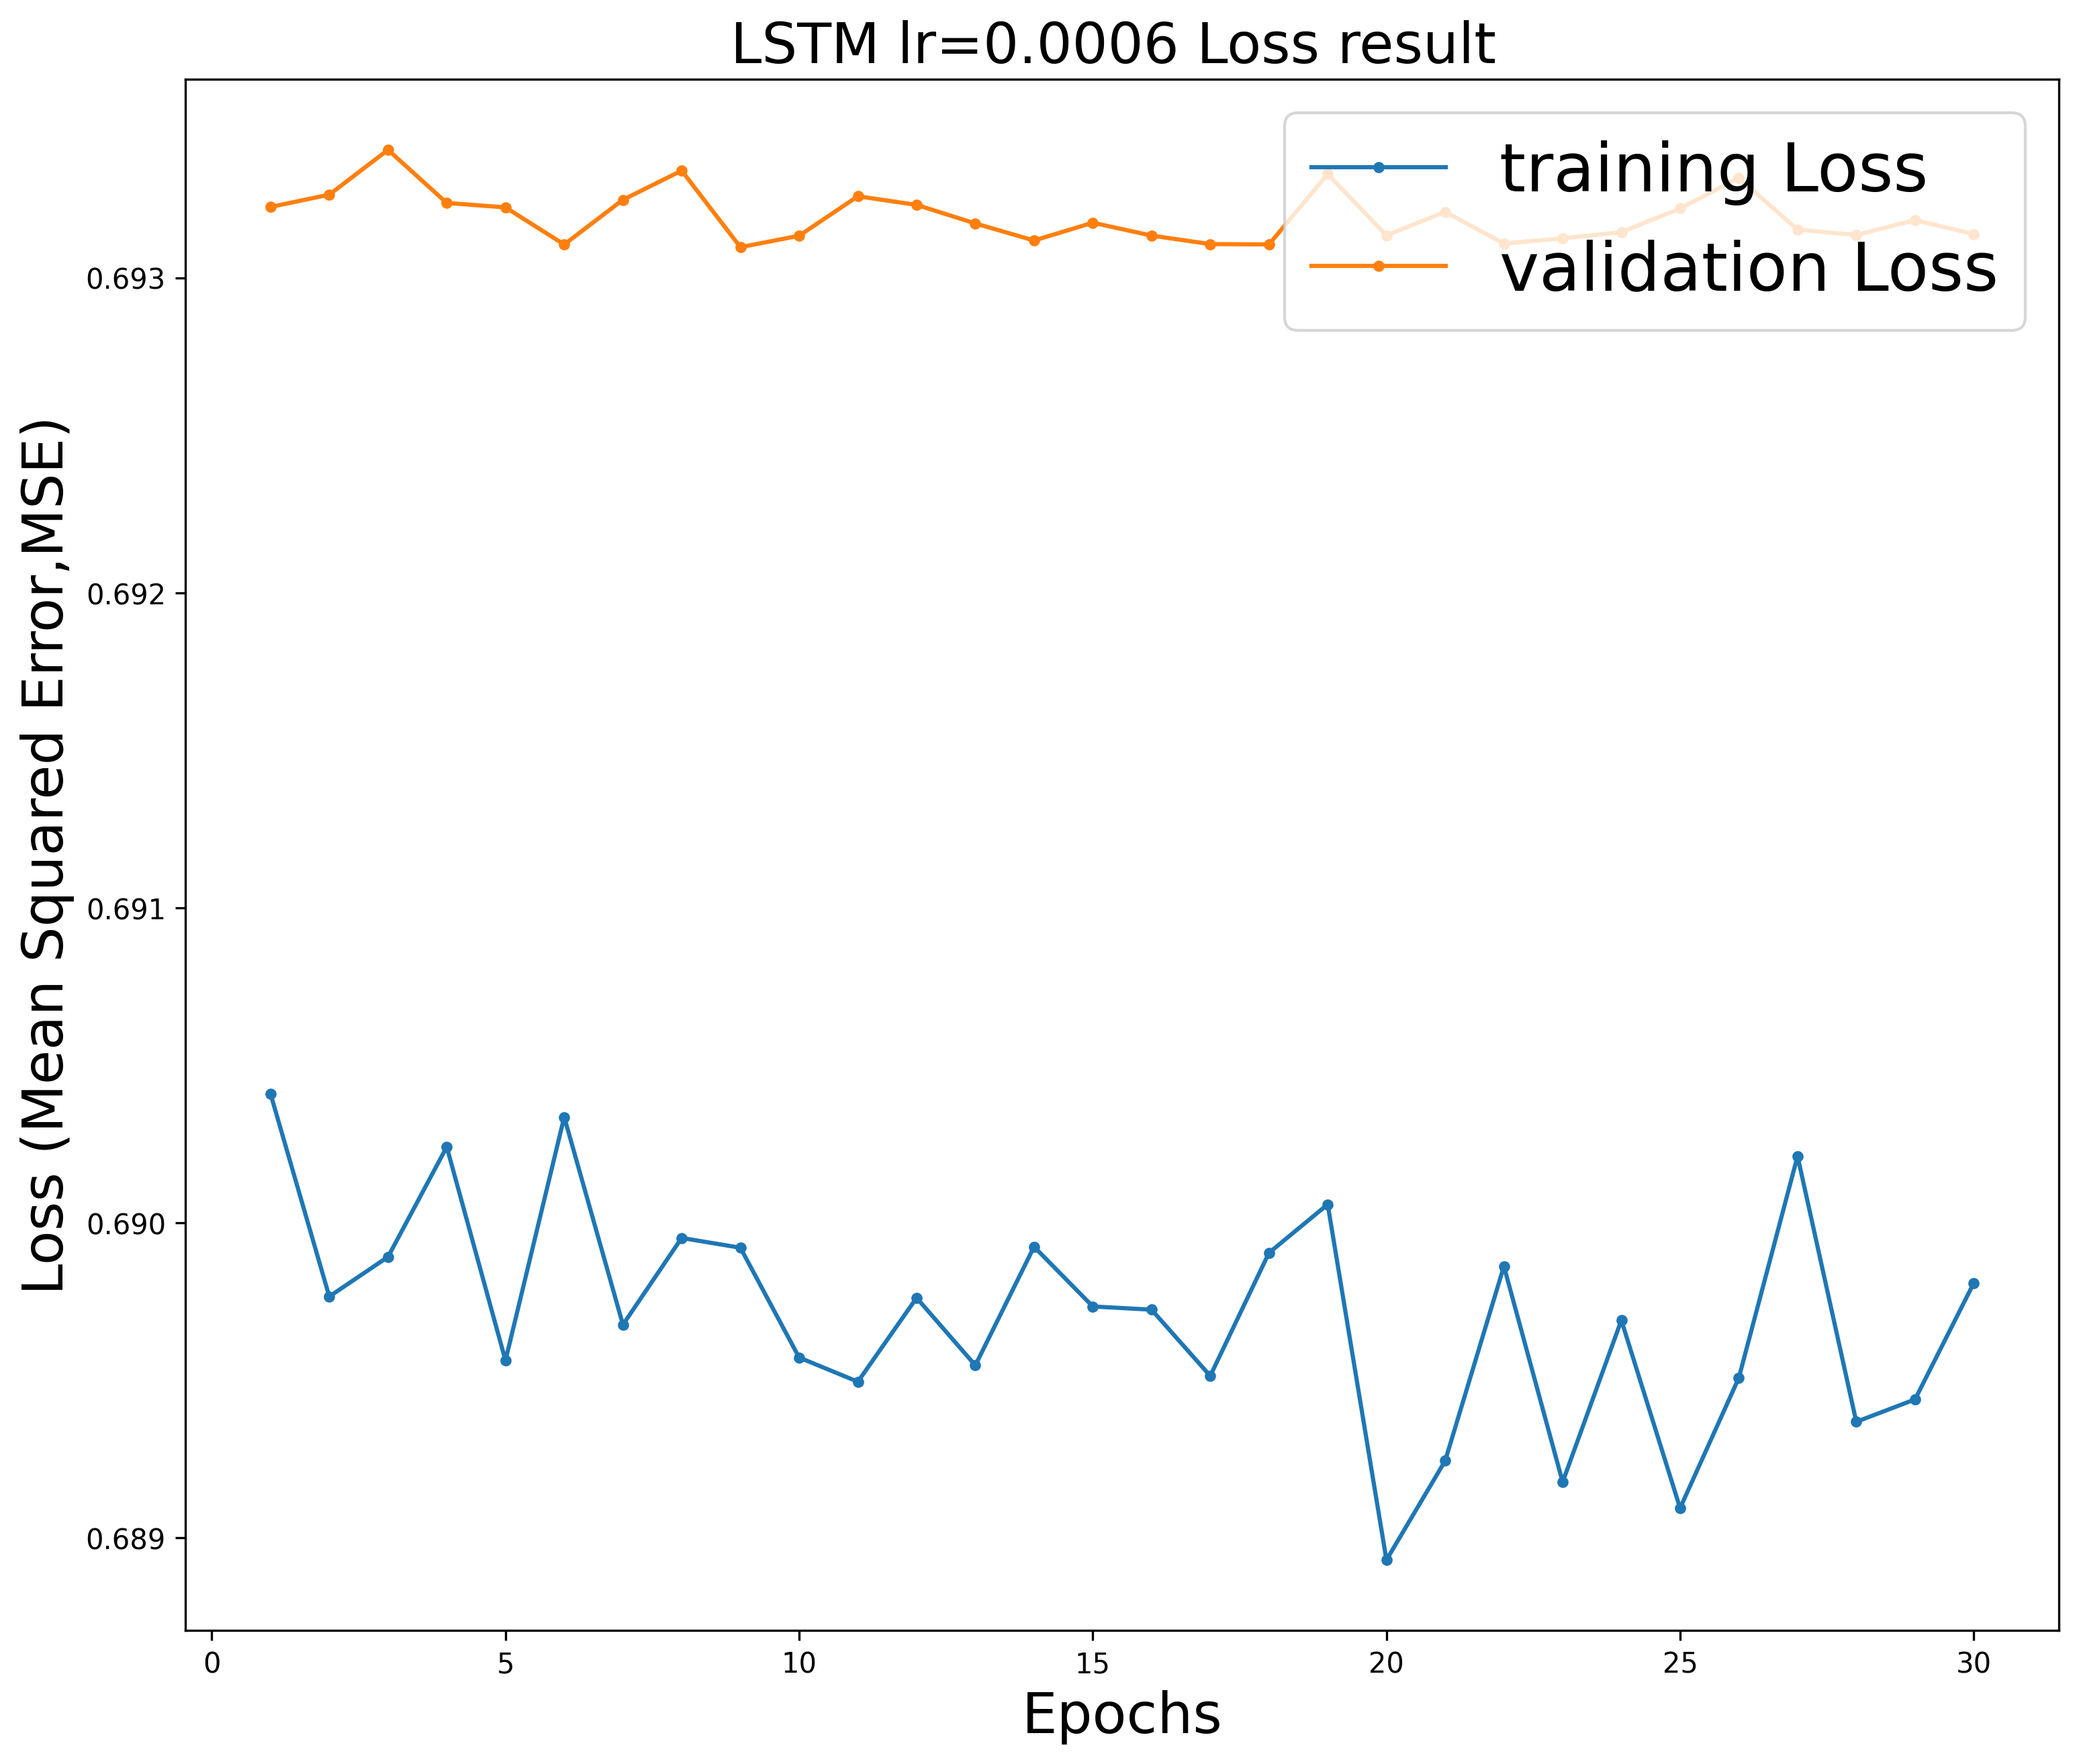

In [ ]:
#Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Mean Squared Error,MSE)',fontsize=20)
plt.title('LSTM lr=0.0006 Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

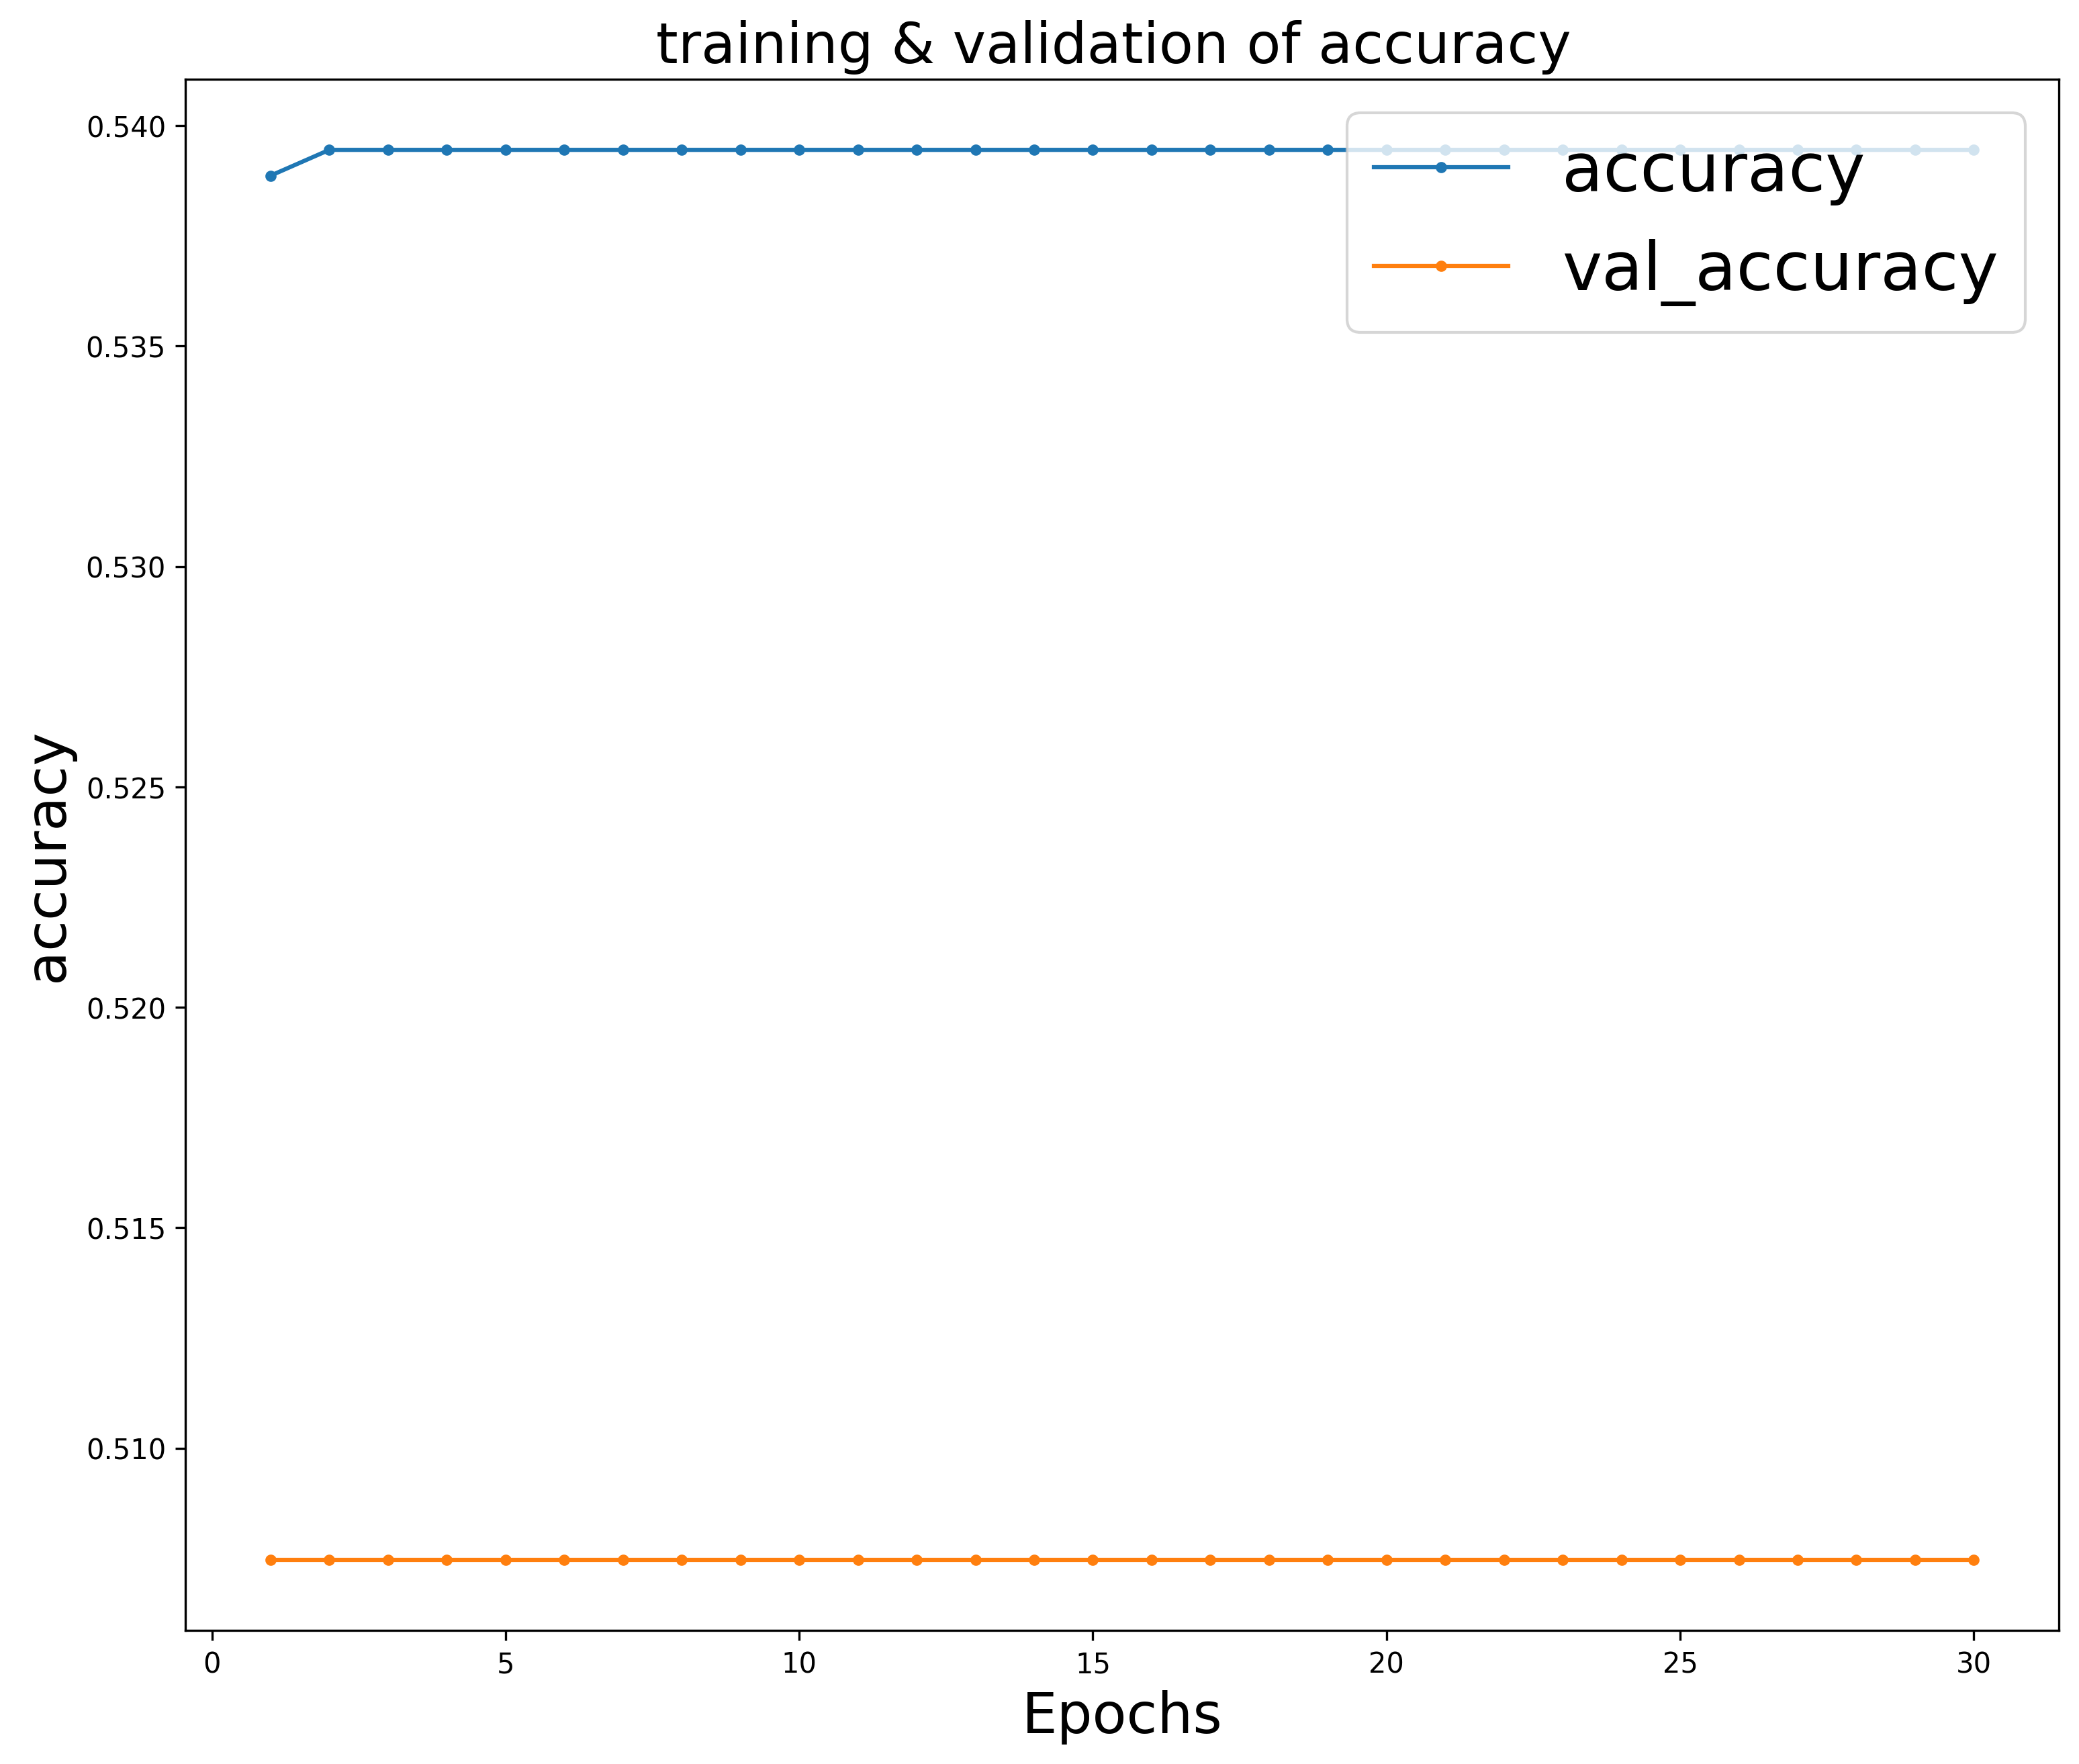

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['accuracy']
val_acc_values=modeling_result['val_accuracy']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('accuracy',fontsize=20)
plt.title('training & validation of accuracy ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='accuracy')
plt.plot(epochs, val_acc_values,marker='.',label='val_accuracy')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# 在測試集上進行預測
predicted_labels = model.predict(X_test)
predicted_labels = np.where(predicted_labels > 0.5, 1, 0)

# 計算準確率
accuracy = np.mean(predicted_labels == y_test)
print('Accuracy:', accuracy)


17/17 [==============================] - 0s 2ms/step
Accuracy: 0.5375939849624061
